# Unit 5 - Financial Planning

In [99]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
from MCForecastTools import MCSimulation

%matplotlib inline

In [108]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc=1.2
my_eth= 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Fetch current BTC price
import json
current_btc = requests.get(btc_url).json()
#print(json.dumps(current_btc, indent=4))
#current_btc.keys()
current_btcprice = current_btc['data']['1']['quotes']['USD']['price']
print(current_btcprice)

# Fetch current ETH price
current_eth = requests.get(eth_url).json()
#print(json.dumps(current_eth, indent=4))
current_ethprice = current_eth['data']['1027']['quotes']['USD']['price']
print(current_ethprice)


# Compute current value of my crpto
my_btc_value = current_btcprice * my_btc
my_eth_value= current_ethprice * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

41754.0
2934.2
The current value of your 1.2 BTC is $50104.80
The current value of your 5.3 ETH is $15551.26


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [113]:
# Set Alpaca API key and secret
alpaca_api_key= os.getenv("ALPACA_API_KEY")
alpaca_secret_key= os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca= tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [90]:
# Format current date as ISO format
today= pd.Timestamp("2022-03-15", tz="America/New_York").isoformat()
#today= pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = TimeFrame.Day
#timeframe =  "1D"

# Get current closing prices for SPY and AGG
df_ticker = alpaca.get_bars(
    ["AGG", "SPY"],
    timeframe,
    start= today, 
    end= today,
    limit=1000
).df

# Display sample data
df_ticker

closes= df_ticker.pivot_table(values="close", index="timestamp", columns="symbol")
closes


symbol,AGG,SPY
timestamp,,
2022-03-15 04:00:00+00:00,107.6,426.17


In [10]:
# Pick AGG and SPY close prices

agg_close_price = closes["AGG"][0]
spy_close_price = closes['SPY'][0]


# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.6
Current SPY closing price: $426.17


In [11]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21308.50
The current value of your 200 AGG shares is $21520.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_value = my_btc_value + my_eth_value
shares_value = my_agg_value + my_spy_value

# Create savings DataFrame
data= {"amount":[crypto_value, shares_value]}
df_savings = pd.DataFrame(data, index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,65656.06
shares,42828.50


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

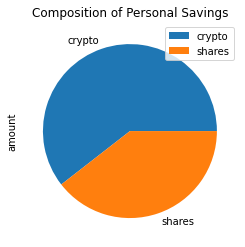

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings")

In [163]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = shares_value + crypto_value

# Validate saving health
if total_savings>emergency_fund:
    print("Congratulations you have enough money in this fund")
elif total_savings == emergency_fund:
    print("Congratulations you have reached your financial goal")
elif total_savings < emergency_fund:
    print("You are {(emergency_fund-total_savings)} dollars away from reaching your goal")

Congratulations you have enough money in this fund


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [95]:
# Set start and end dates of five years back from today.
start_date = pd.Timestamp('2017-03-15', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-03-15', tz='America/New_York').isoformat()


In [123]:
alpaca_api_key= os.getenv("ALPACA_API_KEY")
alpaca_secret_key= os.getenv("ALPACA_SECRET_KEY")

# Created a new API object
api = REST(alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [124]:
# Get 5 years' worth of historical data for SPY and AGG
#created function to fetch historical data, get_barset deprecated and get_bars output data was not
#the correct format for MCSimulations
def get_company(ticker, start_date, end_date, api):
    return api.get_bars(
        ticker,
        TimeFrame.Day,
        start_date,
        end_date
    ).df


In [128]:
#create a dataframe for the tickers' historical data
df_stock_data = {
    "SPY":get_company("SPY", start_date, end_date, api),
    "AGG":get_company("AGG", start_date, end_date, api)
}


In [129]:
#Combine ticker data
total_data = pd.concat(df_stock_data.values(), keys=df_stock_data.keys(), axis="columns")
total_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2017-03-15 04:00:00+00:00  237.56  239.44  237.29  238.8800   96081750   
2017-03-16 04:00:00+00:00  239.12  239.20  238.10  238.4900   78343951   
2017-03-17 04:00:00+00:00  237.79  237.97  237.03  237.1008   89002111   
2017-03-20 04:00:00+00:00  237.03  237.36  236.32  236.7400   52536979   
2017-03-21 04:00:00+00:00  237.49  237.61  233.58  233.7600  131809275   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2017-03-15 04:00:00+00:00      301843  238.366856  107.25  107.79  107.2000   
2017-03-16 04:00:00+00:00      231705  238.640245  107.68  107.75  107.6200   
2017-03-17 04:00:00+00:00      225269  237.526209  107.72  107.91  107.6901   
2017-03-20 04:00:00+00:00      169612  236.909398  107.86  108.05  107.8401   
2017-03-21 04:00:00+00:00      443599  234.853857  107.93  108.27  107.9300   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2017-03-15 04:00:00+00:00  107.78  2163046       10220  107.457310  
2017-03-16 04:00:00+00:00  107.66  2369707       11331  107.677473  
2017-03-17 04:00:00+00:00  107.88  2368799       10846  107.859402  
2017-03-20 04:00:00+00:00  108.05  1635249        8198  107.961544  
2017-03-21 04:00:00+00:00  108.27  2049680       12024  108.175725

In [132]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_returns = MCSimulation(
    portfolio_data= total_data,
    weights = [0.6, 0.4],
    num_simulation = 500, 
    num_trading_days= 252*30
)

In [134]:
# Printing the simulation input data
MC_returns.portfolio_data

SPY                                       \
                              open    high     low     close     volume   
timestamp                                                                 
2017-03-15 04:00:00+00:00  237.560  239.44  237.29  238.8800   96081750   
2017-03-16 04:00:00+00:00  239.120  239.20  238.10  238.4900   78343951   
2017-03-17 04:00:00+00:00  237.790  237.97  237.03  237.1008   89002111   
2017-03-20 04:00:00+00:00  237.030  237.36  236.32  236.7400   52536979   
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.7600  131809275   
...                            ...     ...     ...       ...        ...   
2022-03-09 05:00:00+00:00  425.160  429.51  422.83  427.4100  110780810   
2022-03-10 05:00:00+00:00  422.730  426.43  420.44  425.4800   91933914   
2022-03-11 05:00:00+00:00  428.180  428.77  419.53  420.0700   90803923   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.0000   91930409   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.1700  104219651   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-03-15 04:00:00+00:00      301843  238.366856          NaN  107.25   
2017-03-16 04:00:00+00:00      231705  238.640245    -0.001633  107.68   
2017-03-17 04:00:00+00:00      225269  237.526209    -0.005825  107.72   
2017-03-20 04:00:00+00:00      169612  236.909398    -0.001522  107.86   
2017-03-21 04:00:00+00:00      443599  234.853857    -0.012588  107.93   
...                               ...         ...          ...     ...   
2022-03-09 05:00:00+00:00     1086809  426.130400     0.026811  109.09   
2022-03-10 05:00:00+00:00      891241  423.871044    -0.004516  108.65   
2022-03-11 05:00:00+00:00      809145  424.040193    -0.012715  108.44   
2022-03-14 04:00:00+00:00      863515  419.203845    -0.007308  107.78   
2022-03-15 04:00:00+00:00      920659  422.752423     0.021990  107.83   

                                                                            \
                              high       low   close    volume trade_count   
timestamp                                                                    
2017-03-15 04:00:00+00:00  107.790  107.2000  107.78   2163046       10220   
2017-03-16 04:00:00+00:00  107.750  107.6200  107.66   2369707       11331   
2017-03-17 04:00:00+00:00  107.910  107.6901  107.88   2368799       10846   
2017-03-20 04:00:00+00:00  108.050  107.8401  108.05   1635249        8198   
2017-03-21 04:00:00+00:00  108.270  107.9300  108.27   2049680       12024   
...                            ...       ...     ...       ...         ...   
2022-03-09 05:00:00+00:00  109.209  108.9300  109.04   9873754       29005   
2022-03-10 05:00:00+00:00  108.680  108.2500  108.43  13646915       42329   
2022-03-11 05:00:00+00:00  108.550  108.3400  108.41  10662625       29475   
2022-03-14 04:00:00+00:00  107.816  107.3600  107.36   9492508       34364   
2022-03-15 04:00:00+00:00  107.920  107.4300  107.60  13841071       33852   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-03-15 04:00:00+00:00  107.457310          NaN  
2017-03-16 04:00:00+00:00  107.677473    -0.001113  
2017-03-17 04:00:00+00:00  107.859402     0.002043  
2017-03-20 04:00:00+00:00  107.961544     0.001576  
2017-03-21 04:00:00+00:00  108.175725     0.002036  
...                               ...          ...  
2022-03-09 05:00:00+00:00  109.058720    -0.002105  
2022-03-10 05:00:00+00:00  108.417461    -0.005594  
2022-03-11 05:00:00+00:00  108.421874    -0.000184  
2022-03-14 04:00:00+00:00  107.571987    -0.009685  
2022-03-15 04:00:00+00:00  107.622094     0.002235  

[1260 rows x 16 columns]

In [135]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_returns.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\mokan\Class_Repo\02-Homework\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999419,0.997839,0.987109,0.997277,0.994342,0.999198,0.987791,1.003526,0.997879,0.994075,...,1.000882,0.995553,0.989921,0.999628,0.997553,0.991212,0.991987,0.984796,1.004551,1.002831
2,0.998175,1.001698,0.988698,1.002098,1.003655,1.010024,0.996431,1.010806,1.004679,1.001825,...,1.018754,1.001736,0.983375,0.995594,1.002638,1.000904,0.998938,0.971621,1.006589,1.003675
3,1.006409,1.002202,1.000437,1.005840,0.997669,1.003446,1.014515,1.010779,0.996248,1.006497,...,1.011577,0.998241,0.989568,0.993604,1.016438,0.993304,0.998232,0.975301,1.014648,1.009707
4,1.009139,1.008922,0.995183,1.009655,1.014040,0.998485,1.013419,1.000106,0.997063,1.011377,...,1.006269,0.989267,1.002128,0.998583,0.998706,0.991674,1.006724,0.969882,1.004641,1.002548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.841916,9.069290,3.494896,6.324783,8.917931,3.248468,4.126133,6.760578,8.485080,12.259164,...,4.669027,7.997233,7.307044,10.499429,5.113677,18.150860,5.667733,4.091313,14.365493,6.209743
7557,8.840388,9.150907,3.494251,6.367502,8.903589,3.243578,4.165395,6.809615,8.450846,12.321305,...,4.688260,8.011151,7.340421,10.536770,5.107497,18.156430,5.559306,4.081258,14.395213,6.209677
7558,8.804397,9.191684,3.482402,6.344003,8.952882,3.241726,4.166489,6.855859,8.455797,12.236712,...,4.725525,7.917661,7.286394,10.651212,5.107998,17.990854,5.621989,4.070899,14.395707,6.183014
7559,8.860166,9.209258,3.496408,6.337031,8.970227,3.235648,4.129513,6.882438,8.412257,12.196957,...,4.753750,7.940795,7.360810,10.610228,5.150022,17.963506,5.728247,4.080789,14.466321,6.148020


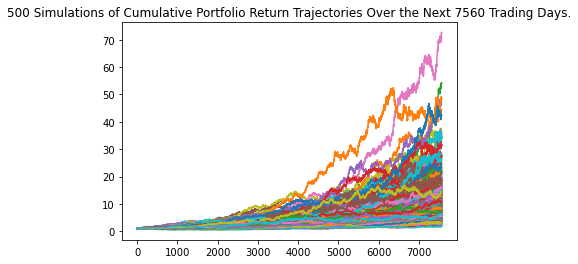

In [136]:
# Plot simulation outcomes
line_plot = MC_returns.plot_simulation()

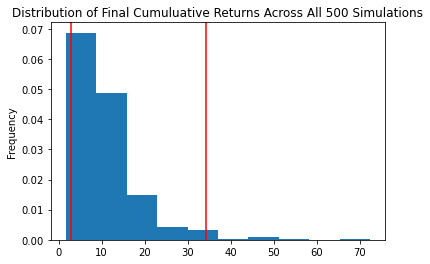

In [137]:
# Plot probability distribution and confidence intervals
dist_plot = MC_returns.plot_distribution()

### Retirement Analysis

In [138]:
# Fetch summary statistics from the Monte Carlo simulation results
summary= MC_returns.summarize_cumulative_return()

# Print summary statistics
summary

count           500.000000
mean             10.897260
std               8.072410
min               1.685051
25%               5.710514
50%               8.918996
75%              13.714718
max              72.439589
95% CI Lower      2.846835
95% CI Upper     34.266327
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [139]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary[8]*20000, 2)
ci_upper = round(summary[9]*20000, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $56936.71 and $685326.53


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [140]:
# Set initial investment
initial_investment = 20000 * 1.5
initial_investment

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary[8]*20000*1.5, 2)
ci_upper = round(summary[9]*20000*1.5, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $85405.06 and $1027989.8


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [157]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns with similar allocations but different initial investment
MC_returns_five = MCSimulation(
    portfolio_data= total_data,
    weights = [0.6, 0.4],
    num_simulation = 500, #change to 500 when the code works
    num_trading_days= 252*5
)

In [158]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_returns_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\mokan\Class_Repo\02-Homework\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004263,1.001917,1.006214,1.006362,1.012450,1.001431,0.981758,0.991314,1.011769,0.990639,...,0.993058,1.002615,0.991793,1.021396,1.011648,0.998731,1.007853,1.002625,0.994838,1.005859
2,1.006426,1.011498,1.007026,1.017476,1.012475,0.997870,0.973776,0.991003,0.993467,0.994981,...,0.991179,1.004831,1.004588,1.023293,1.009551,1.001270,0.998984,1.005830,0.998366,1.012440
3,0.996229,1.009412,1.017589,1.009548,1.033025,1.009486,0.968024,0.989064,1.011035,0.997155,...,0.986757,1.000850,1.012571,1.027343,1.010660,1.010161,0.983934,1.000843,0.999774,0.998452
4,0.984253,1.025696,1.012731,1.010156,1.031632,1.008636,0.964612,1.000571,1.005694,1.013872,...,0.985333,0.991307,1.007970,1.027123,1.014145,1.007191,0.978110,1.003922,0.988996,1.000767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.666164,1.207668,1.684814,1.349097,1.099293,1.158180,1.828586,1.017346,1.368611,1.395378,...,1.403262,1.482376,1.440527,1.061879,2.507464,1.303597,1.454940,1.166262,0.793299,1.688446
1257,1.680408,1.214180,1.683935,1.352515,1.101458,1.160163,1.832697,1.019968,1.352199,1.397917,...,1.410555,1.488531,1.423723,1.059562,2.510551,1.291645,1.451855,1.165377,0.802477,1.693092
1258,1.669358,1.233854,1.663703,1.339473,1.109551,1.150715,1.860080,1.026550,1.349225,1.414543,...,1.402670,1.492493,1.425142,1.059106,2.508772,1.285350,1.445243,1.166078,0.804966,1.694427
1259,1.667618,1.240188,1.655673,1.348875,1.111087,1.150773,1.865609,1.021448,1.345039,1.422950,...,1.396334,1.495389,1.411076,1.053582,2.509494,1.262690,1.465699,1.177551,0.800998,1.676878


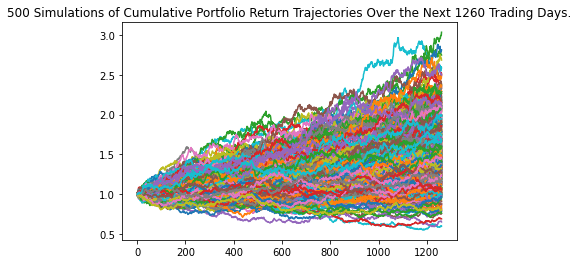

In [159]:
# Plot simulation outcomes
line_plot_five= MC_returns_five.plot_simulation()

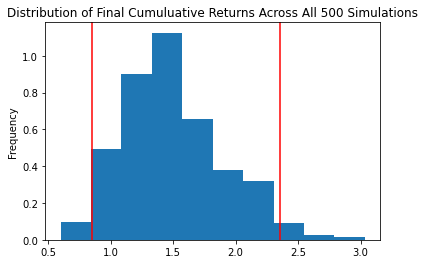

In [160]:
# Plot probability distribution and confidence intervals
dist_plot_five = MC_returns_five.plot_distribution()

In [161]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_five = MC_returns_five.summarize_cumulative_return()

# Print summary statistics
summary_five

count           500.000000
mean              1.498354
std               0.395641
min               0.598549
25%               1.218402
50%               1.432387
75%               1.721383
max               3.034364
95% CI Lower      0.853525
95% CI Upper      2.356722
Name: 1260, dtype: float64

In [162]:
# Set initial investment
initial_investment = 65000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_five[8]*65000, 2)
ci_upper_five = round(summary_five[9]*65000, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $65000 in the portfolio over the next 5 years will end within in the range of $55479.15 and $153186.96


### Ten Years Retirement Option

In [164]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_returns_ten = MCSimulation(
    portfolio_data= total_data,
    weights = [0.6, 0.4],
    num_simulation = 500, #change to 500 when the code works
    num_trading_days= 252*10
)

In [152]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_returns_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992004,1.014590,1.012032,1.006019,0.995769,1.006651,0.995740,0.994995,0.991075,1.000839,...,0.994763,0.987115,1.013324,1.000679,0.992492,1.010425,0.996207,0.999603,0.991213,0.997218
2,0.994667,1.005514,1.011427,1.004821,1.012495,1.000655,0.997303,0.988252,1.017189,0.998685,...,0.995641,0.980203,1.018368,0.990017,0.997174,1.007426,0.992561,1.005855,0.993605,0.997508
3,1.003665,1.011513,0.999257,1.008573,1.008440,0.993275,0.996298,0.979983,0.988985,0.997290,...,1.010071,0.969109,1.001754,0.986169,0.975813,1.006166,1.003554,1.020004,0.978050,0.997247
4,0.999939,1.016089,0.991191,1.003385,1.010500,0.986925,1.012820,0.988376,0.983956,0.990575,...,1.013152,0.965939,1.011010,0.981110,0.976233,0.997836,1.004570,1.024524,0.977082,1.004533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.498245,1.212168,2.273603,1.893241,2.325673,2.516546,3.485903,0.954903,2.064616,2.150960,...,1.706081,2.303206,3.011607,2.017907,1.650202,3.073003,2.201548,2.998186,2.104654,1.128059
2517,1.505641,1.191868,2.277273,1.900762,2.316890,2.473320,3.480164,0.962254,2.043762,2.165006,...,1.709442,2.334296,3.025635,2.007803,1.675098,3.058201,2.199330,2.978527,2.122854,1.126378
2518,1.506954,1.195127,2.285320,1.893883,2.300435,2.476228,3.457671,0.953701,2.023753,2.172773,...,1.698817,2.343837,2.988079,2.017105,1.670579,3.041687,2.216042,2.973426,2.096990,1.123377
2519,1.518501,1.188407,2.280409,1.865043,2.315906,2.479969,3.480237,0.960146,2.051218,2.186784,...,1.703533,2.352524,2.988045,2.014307,1.661891,3.046860,2.232925,3.005231,2.099680,1.117088


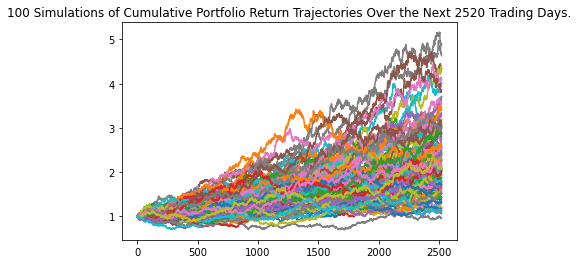

In [153]:
# Plot simulation outcomes
MC_returns_ten_plot= MC_returns_ten.plot_simulation()

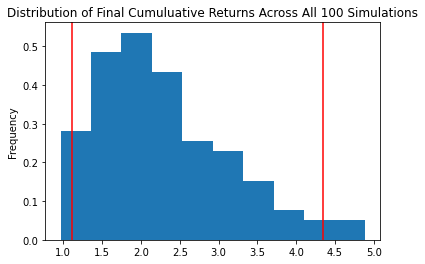

In [154]:
# Plot probability distribution and confidence intervals
dist_plot_ten = MC_returns_ten.plot_distribution()

In [155]:
# Fetch summary statistics from the Monte Carlo simulation results
table_ten = MC_returns_ten.summarize_cumulative_return()

# Print summary statistics
table_ten

count           100.000000
mean              2.305858
std               0.855688
min               0.963487
25%               1.684469
50%               2.115035
75%               2.873925
max               4.885410
95% CI Lower      1.113454
95% CI Upper      4.346352
Name: 2520, dtype: float64

In [156]:
# Set initial investment
initial_investment=65000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_five[8]*65000, 2)
ci_upper_ten = round(summary_five[9]*65000, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $65000 in the portfolio over the next 10 years will end within in the range of $53256.63 and $217836.47
